# Aulas 05/06 - Séries Temporais

# Fundamentos de Previsão

Material original: Prof. Dr. Eduardo Lobo Lustosa Cabral

Adaptação e atualização: Prof. Dr. Vitor Alex Oliveira Alves


## 1. Objetivos

O objetivo dessa aula é apresentar algumas ferramentas para realizar previsões e analisar séries temporais. Tais ferramentas incluem:

- Métodos simples de previsão;

- Formas de simplificar a tarefa de previsão usando transformações e ajustes dos dados;

- Métodos para avaliar a qualidade de previsões e desempenho de um modelo;

- Técnicas para calcular intervalos de confiança;

- Técnica para identificar anomalia do tipo *outlier*.


Os métodos simples para realizar previsões são:

1. Método base;
2. Método base para dados com sazonalidade;
3. Método de tendência;
4. Média móvel;
5. Média móvel ponderada.

O uso desses métodos nos permite:

- Determinar tendências;
- Identificar anomalias do tipo *outlier* ;
- Realizar previsões.

### Importação das principais bibliotecas

In [1]:
import numpy as np                              
import pandas as pd                             
import matplotlib.pyplot as plt               
import tensorflow as tf
import os

%matplotlib inline

## 2. Métodos simples


Alguns métodos de previsão são extremamente simples e surpreendentemente efetivos. Geralmente, esse métodos são usados como base comparativa na avaliação de outros métodos mais complexos.


### 2.1 Modelo base

Vamos começar usando um modelo baseado em uma hipótese ingênua: "o valor da série no instante de tempo seguinte é igual ao valor atual". Esse modelo é definido matematicamente por:

$$\hat{y}_{t} = y_{t-1}$$

em que $y_{t-1}$ é a amostra no instante de tempo $t - T_a$, $T_a$ é o período de amostragem (intervalo de tempo entre a coleta de duas amostras) e $\hat{y}_{t}$ é o valor previsto para a série no instante de tempo $t$.

Observe que:

* as previsões desse modelo consitem nos valores da série original atrasados de um período de amostragem. 
* o modelo consiste de uma linha de base para quaisquer problemas de previsão de série temporal (problemas que, às vezes, são impossíveis de superar).

O código para implementar esse modelo segue abaixo.

In [2]:
# Modelo base
def BaseModel(series):
    N = len(series)
    y = series.copy()
    for t in range(1, N):
        y.iloc[t] = series.iloc[t-1]
    return y

### 2.2. Método base para séries com sazonalidade

Existe um método similar ao método base, que é útil para séries com sazonalidade bem definida. Nesse caso, a previsão é definida como sendo igual ao último valor observado da mesma temporada anterior. Sendo assim, para uma série que apresenta sazonalidade anual, usa-se o valor da amostra do mesmo mês do ano anterior.

Nesse método, a previsão para o próximo instante de tempo é dada por:

$$\hat {y_{t}} = y_{t-s}$$

em que $\hat{y}_{t}$ é o valor previsto para a série no instante de tempo $t$, $y_{t-s}$ é a amostra no instante de tempo equivalente da temporada anterior e $s$ é o número de amostras de cada temporada.

Essa equação pode parecer mais complicada do que parece. Como exemplo, considere uma série com sazonalidade anual. Então, todos os valores do mês de fevereiro serão iguais às observações do mês de fevereiro do ano anterior. 

O código para implementar esse modelo segue abaixo.

In [3]:
def SazonalBaseModel(series, s):
    N = len(series)
    y = series.copy()
    for t in range(s, N):
        y.iloc[t] = series.iloc[t-s]
    return y

### 2.3 Modelo de tendência simples

Uma variação do método base consiste em introduzir a tendência dos dados na previsão. Essa tendência é calculada considerando que a mudança ao longo do tempo é definida como a variação entre a última amostra e a amostra $m$ instantes de tempo atrás.

Nesse caso, a previsão para o tempo $t$ é dada por:

$$\hat {y_{t}} = y_{t-1} + \frac {(y_{t-1} - y_{t-m})}{m-1}$$

em que $\hat{y}_{t}$ é o valor previsto para a série no instante de tempo $t$, $y_{t-1}$ é a amostra no instante de tempo $t - T_a$, $y_{t-m}$ é a amostra coletada $m$ instantes atrás.

Isso equivale a traçar uma linha entre a primeira e a $m$-ésima amostra anterior e extrapolá-la para o futuro.

O código abaixo implementa esse modelo.

In [4]:
def trend_model(series,m):
    N = len(series)
    y = series.copy()
    for t in range(1, N):
        y.iloc[t] = series.iloc[t-1] + (series.iloc[t-1] - series.iloc[t-m])/(m-1)
    return y

### 2.4 Exemplos

Vamos usar esses modelos simples para prever o próximo dado em duas séries:

1. Temperatura na próxima hora da série "The weather dataset" (https://www.bgc-jena.mpg.de/wetter/), criado pelo Max Planck Institute for Biogeochemistry.

2. Produção de cerveja na Austrália da série "Monthly beer production in Australia" (https://www.kaggle.com/code/rezadastranj/monthly-beer-production-in-australia-forecast/data).

Para avaliar as previsões realizadas, vamos usar o *Erro Absoluto Médio Percentual* - MAEP. Esse erro é calculado como uma porcentagem, formato conveniente quando se quer analisar a qualidade de um resultado. A expressão do MAEP é

$$MAEP = \frac{100}{N}\sum\limits_{i=1}^{N} \frac{|y_i - \hat{y}_i|}{y_i}$$ 

em que $y_i$ é um dado da série, $\hat{y}_i$ é o valor previsto para esse dado e $N$ é o número de dados (amostras) da série.

A função para o cálculo do MAEP é mostrada a seguir.

In [5]:
# Função para calcular o erro médio absoluto percentual (MAEP)
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / np.mean(y_true))) * 100

** IMPORTANTE** Observe que na definição da função `mean_absolute_percentage_error` foi utilizada a média das amostras no denominador, ao invés do valor da amostra em cada instante de tempo. Isso previne a (possível) divisão por zero.

### Série de temperaturas

In [6]:
# Download do arquivo da série de temperaturas
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

# Conversão dos dados para formato Pandas DataFrame
df_temp = pd.read_csv(csv_path)
# Tamanho do arquivo
print(f'Dimensão dos dados (arquivo original) = {df_temp.shape}')

# Decimação dos dados
# Tempo de amostragem original = 10 minutos
# Tempo de amostragem desejado = 1 hora
# Assim, tomaremos 1 amostra a cada 6
df_temp = df_temp[5::6]

# Informações após decimação
print(f'Dimensão dos dados após decimação = {df_temp.shape}')
print(f'Colunas disponíveis para análise:\n{df_temp.columns}')
display(df_temp)

13568290/13568290 [==============================] - 0s 0us/step
Dimensão dos dados (arquivo original) = (420551, 15)
Dimensão dos dados após decimação = (70091, 15)
Colunas disponíveis para análise:
Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420521,31.12.2016 19:10:00,1002.18,-0.98,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,0.87,1.36,190.6
420527,31.12.2016 20:10:00,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,1.02,1.92,225.4
420533,31.12.2016 21:10:00,1001.19,-2.75,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,0.71,1.56,158.7
420539,31.12.2016 22:10:00,1000.65,-2.89,270.22,-7.15,72.30,4.93,3.57,1.37,2.22,3.57,1288.03,0.35,0.68,216.7


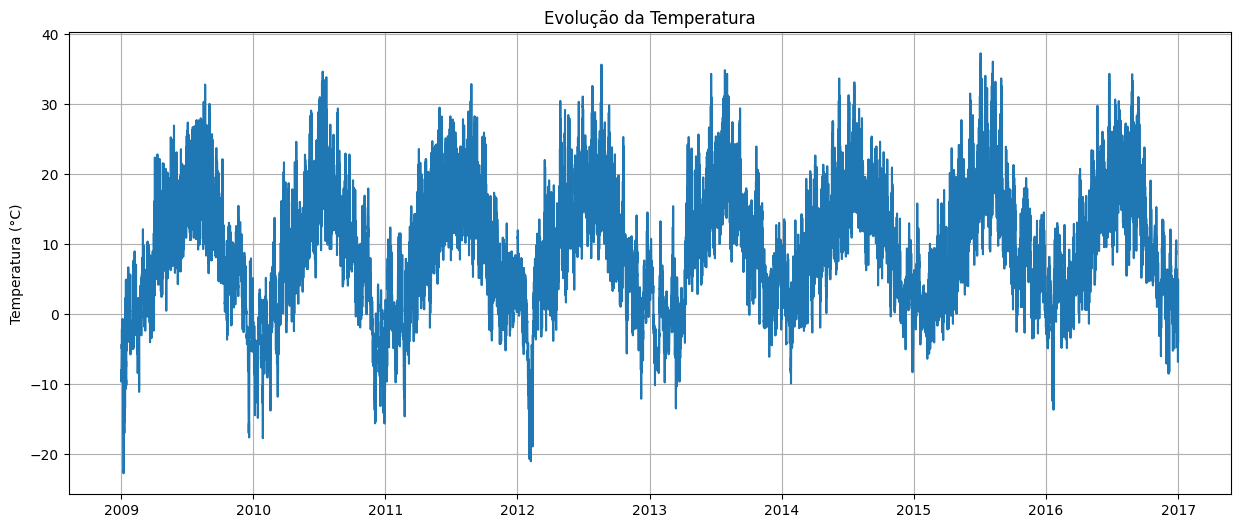

In [7]:
# Retirando a coluna data-hora
date_time = pd.to_datetime(df_temp.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
# Plotagem da série de temperaturas
plt.figure(figsize=(15,6))
plt.title('Evolução da Temperatura')
plt.plot(date_time, df_temp['T (degC)'])
plt.ylabel('Temperatura (°C)')
plt.grid(True)
plt.show()

Cálculo das previsões usando os 3 modelos simples:

- Para o modelo de tendência adotaremos $m=2$, ou seja, usaremos a última e a penúltima amostras para extrapolar o novo valor;
- No modelo de sazonalidade é usada uma sazonalidade $s=24$ horas, que é a sazonalidada mais curta esperada para um registro de temperatura.

In [8]:
# Calcula a previsão de temperatura usando modelo base 
y_base_temp = BaseModel(df_temp['T (degC)'])

# Calcula a previsão de temperatura usando modelo de tendências
y_trend_temp = trend_model(df_temp['T (degC)'], 2)

# Calcula a previsão de temperatura usando modelo sazonal
y_sazonal_temp = SazonalBaseModel(df_temp['T (degC)'], 24)

Vamos agora examinar o comportamento das previsões nas últimas 72 horas de registro da série de temperaturas (29.12.2016 a 31.12.2016). Para isso, basta usarmos o *slice* `[-72:]` nos vetores de interesse.

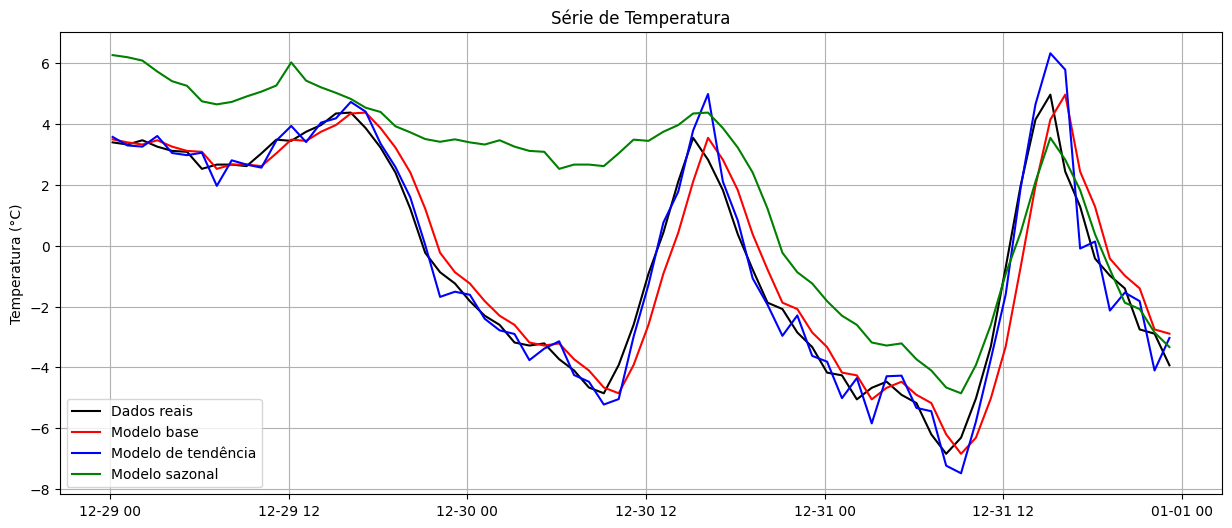

In [9]:
# Plotando a série original e as previsões
plt.figure(figsize=(15,6))
plt.title('Série de Temperatura')
plt.plot(date_time[-72:], df_temp['T (degC)'].iloc[-72:], 'k', label='Dados reais')
plt.plot(date_time[-72:], y_base_temp[-72:], 'r', label='Modelo base')
plt.plot(date_time[-72:], y_trend_temp[-72:], 'b', label='Modelo de tendência')
plt.plot(date_time[-72:], y_sazonal_temp[-72:], 'g', label='Modelo sazonal')
plt.ylabel('Temperatura (°C)')
plt.grid(True)
plt.legend()
plt.show()

#### Erros de previsão.

In [10]:
# Cálculo do Erro Absoluto Médio Percentual - MAEP
# IMPORTANTE: TODA a série e correspondentes previsões foram utilizadas
erro_base = mean_absolute_percentage_error(df_temp['T (degC)'], y_base_temp)
erro_trend = mean_absolute_percentage_error(df_temp['T (degC)'], y_trend_temp)
erro_sazonal = mean_absolute_percentage_error(df_temp['T (degC)'], y_sazonal_temp)

# Resultados
print(f'Erro modelo base = {erro_base:.2f}%')
print(f'Erro modelo de tendência = {erro_trend:.2f}%')
print(f'Erro modelo de sazonalidade = {erro_sazonal:.2f}%')

Erro modelo base = 7.53%
Erro modelo de tendência = 6.53%
Erro modelo de sazonalidade = 27.63%


CONCLUSÕES:

* O modelo que apresenta o menor erro é o modelo de tendência usando os dois dados anteriores (a temperatura da próxima hora é calculada em função da temperatura aferida nas duas últimas horas);

* O pior modelo nesse caso é o de sazonalidade. Apesar da temperatura apresentar clara sazonalidade diária, ocorre muita variação de um dia para outro.

### Série de produção de cerveja

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# Carrega conjunto de dados
df_beer = pd.read_csv('/content/drive/MyDrive/Datasets/monthly-beer-production-in-austr.csv')
print(f'Dimensão dos dados = {df_beer.shape}')
df_beer.head()

Dimensão dos dados = (476, 2)


,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [13]:
# Separa coluna do mês
month = pd.to_datetime(df_beer.pop('Month'))

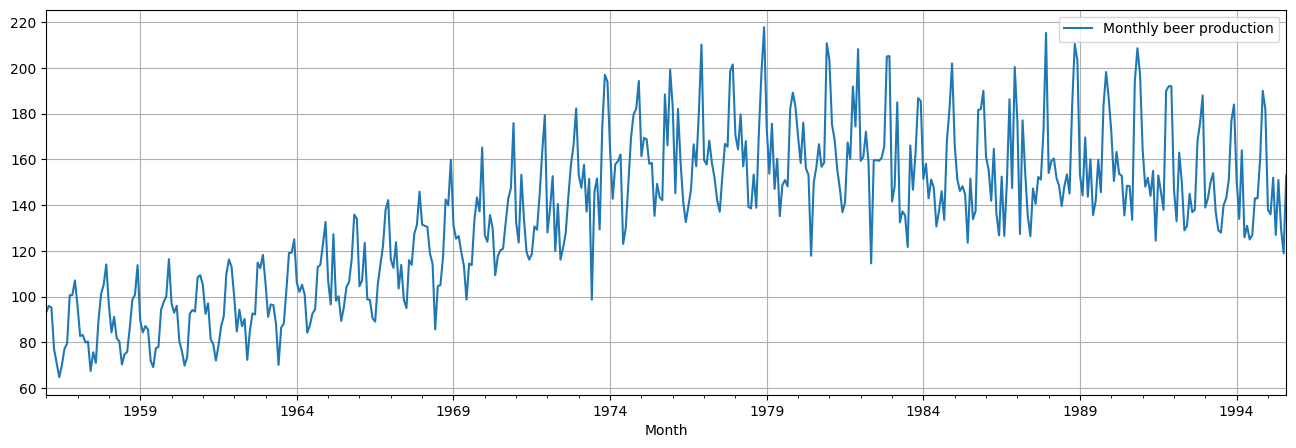

In [14]:
# Gráfico da série de dados
plot_cols = ['Monthly beer production']
plot_features = df_beer[plot_cols]
plot_features.index = month
_ = plot_features.plot(subplots=True, figsize = (16,5))
plt.grid(True)

Cálculo das previsões usando os 3 modelos simples.

* Para o modelo de tendência, adotaremos $m=2$. Desse modo, empregaremos a última e a penúltima amostras para extrapolar o novo valor;
* No modelo de sazonalidade, adotaremos sazonalidade de um ano ($s=12$ meses).

In [15]:
# Calcula a previsão de produção de cerveja usando modelo base 
y_base_beer = BaseModel(df_beer['Monthly beer production'])

# Calcula a previsão de produção de cerveja usando o modelo de tendências 
y_trend_beer = trend_model(df_beer['Monthly beer production'], 2)

# Calcula a previsão de produção de cerveja usando o modelo de sazonalidade 
y_sazonal_beer = SazonalBaseModel(df_beer['Monthly beer production'], 12)

Vamos agora examinar o comportamento das previsões nos últimos 24 meses de registro da série de produção de cerveja (setembro de 1993 a agosto de 1995). Para isso, basta usarmos o *slice* `[-24:]` nos vetores de interesse.

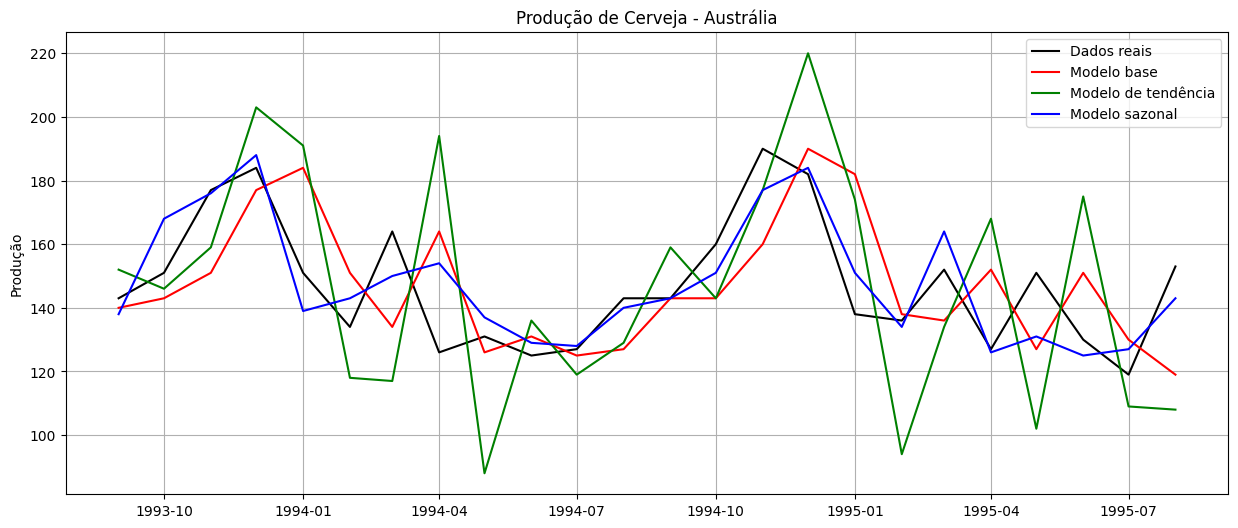

In [16]:
plt.figure(figsize=(15,6))
plt.title('Produção de Cerveja - Austrália')
plt.plot(month[-24:], df_beer['Monthly beer production'].iloc[-24:], 'k', label='Dados reais')
plt.plot(month[-24:], y_base_beer[-24:], 'r', label='Modelo base')
plt.plot(month[-24:], y_trend_beer[-24:], 'g', label='Modelo de tendência')
plt.plot(month[-24:], y_sazonal_beer[-24:], 'b', label='Modelo sazonal')
plt.ylabel('Produção')
plt.grid(True)
plt.legend()
plt.show()

####Erros de previsão

In [17]:
# Cálculo do Erro Absoluto Médio Percentual - MAEP
# IMPORTANTE: TODA a série e correspondentes previsões foram utilizadas
erro_base = mean_absolute_percentage_error(df_beer['Monthly beer production'], y_base_beer)
erro_trend = mean_absolute_percentage_error(df_beer['Monthly beer production'], y_trend_beer)
erro_sazonal = mean_absolute_percentage_error(df_beer['Monthly beer production'], y_sazonal_beer)

# Resultados
print(f'Erro modelo base = {erro_base:.2f}%')
print(f'Erro modelo de tendência = {erro_trend:.2f}%')
print(f'Erro modelo de sazonalidade = {erro_sazonal:.2f}%')

Erro modelo base = 10.88%
Erro modelo de tendência = 17.38%
Erro modelo de sazonalidade = 6.69%


CONCLUSÃO:

* Nesse caso, o modelo que apresenta o menor erro é o modelo de sazonalidade e o que apresenta o maior erro é o modelo de tendência.

**IMPORTANTE:** Não existe um melhor modelo para qualquer série $\to$ o melhor modelo depende dos dados.

## 3. Transformações e pré-processamento dos dados

O ajuste e pré-processamento dos dados de uma série temporal muitas vezes torna a tarefa de previsão/análise mais simples. Existem muitas forma de pré-processamento dos dados de uma série temporal e a melhor forma depende de cada série.

Nesse curso, examinaremos quatro tipos de ajustes e pré-processamento: 

1. Ajustes de calendário;
2. Ajustes de população;
3. Ajustes de inflação;
4. Transformações matemáticas. 

O objetivo de realizar ajustes e transformações nos dados é simplificar os padrões presentes, removendo fontes conhecidas de variação ou mesmo tornando o padrão mais consistente em todo o conjunto de dados. É fato conhecido que padrões mais simples geralmente levam a previsões mais precisas!

Observa-se que, além dessas transformações, pode também ser necessário realizar alguma forma de normalização dos dados, especialmente se o modelo de previsão se tratar de uma rede neural.

### 3.1 Ajustes de calendário

Algumas das variações observadas nos dados sazonais podem ser devidas a simples efeitos de calendário. Nesses casos, geralmente é muito mais fácil remover a variação antes de ajustar um modelo de previsão. 

Por exemplo, se estivermos estudando a produção mensal de uma fábrica, ou o total mensal de vendas de uma loja, haverá variação entre os meses simplesmente por causa dos diferentes números de dias em cada mês, além da variação sazonal ao longo do ano.

No caso de uma série que representa a produção mensal de uma fábrica, basta ajustar os dados de produção usando a média da produção da fábrica em cada dia do mês, dividindo a produção mensal pelo número de dias do mês. Ao olhar para a produção média diária em vez da produção mensal total, remove-se efetivamente a variação devida aos diferentes números de dias de cada mês. 

Um ajuste semelhante pode ser feito para dados de vendas quando o número de dias de negociação em cada mês varia. Nesse caso, as vendas médias por dia útil podem ser modeladas em vez das vendas totais de cada mês.

O `Pandas` fornece funções para manipular datas e horas. Com elas, podemos criar um `DataFrame` de calendário especificando o dia de início e número de períodos. 

No exemplo a seguir, criamos um `DataFrame` de datas iniciando em 01.01.2012, com periodicidade mensal e considerando 12 meses.

In [18]:
# Criação de um DataFrame com:
# - datas iniciando em 01.01.2012
# - periodicidade mensal
# - período de 12 meses
df = pd.DataFrame({'date': pd.date_range(start='/01/01/2012', periods=12, freq='M')})
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['days_in_month'] = df['date'].dt.days_in_month
display(df)

,date,year,month,days_in_month
0,2012-01-31,2012,1,31
1,2012-02-29,2012,2,29
2,2012-03-31,2012,3,31
3,2012-04-30,2012,4,30
4,2012-05-31,2012,5,31
5,2012-06-30,2012,6,30
6,2012-07-31,2012,7,31
7,2012-08-31,2012,8,31
8,2012-09-30,2012,9,30
9,2012-10-31,2012,10,31


Vamos usar a série "Milk Production" do Kaggle para realizar esse tipo de ajuste nos dados (https://www.kaggle.com/code/naffyy/milk-production-data).

In [19]:
# Leitura dos dados
df_milk_original = pd.read_csv('/content/drive/MyDrive/Datasets/monthlyMilkProduction.csv')
print(f'Colunas disponíveis para análise:\n{df_milk_original.columns}')
# Criação do DataFrame de interesse
df_milk = pd.DataFrame({'Year': df_milk_original['Year'],
                        'Month': df_milk_original['Month'],
                        'Milk.Prod': df_milk_original['Milk.Prod']})
print(f'Dimensão dos dados = {df_milk.shape}')
df_milk.head()

Colunas disponíveis para análise:
Index(['Year', 'Month', 'Cotagecheese.Prod', 'Icecream.Prod', 'Milk.Prod',
       'N.CA.Fat.Price', 'Month.Count', 'monthNumSqred', 'monthNumCubed'],
      dtype='object')
Dimensão dos dados = (228, 3)


,Year,Month,Milk.Prod
0,1995,Jan,2.112
1,1995,Feb,1.932
2,1995,Mar,2.162
3,1995,Apr,2.130
4,1995,May,2.227


A seguir, vamos ajustar os dados de produção de leite empregando a produção média diária. Para isso, precisamos incluir no `DataFrame df_milk`a contagem de dias de cada mês.

In [20]:
# Incluindo a contagem de dias de cada mês no DataFrame
df_milk['date'] = pd.DataFrame({'date': pd.date_range(start='/01/01/1995', periods=df_milk.shape[0], freq='M') })
df_milk['days_in_month'] = df_milk['date'].dt.days_in_month
df_milk.head()

,Year,Month,Milk.Prod,date,days_in_month
0,1995,Jan,2.112,1995-01-31,31
1,1995,Feb,1.932,1995-02-28,28
2,1995,Mar,2.162,1995-03-31,31
3,1995,Apr,2.130,1995-04-30,30
4,1995,May,2.227,1995-05-31,31


Nesse ponto é interessante examinarmos a série original e a série corrigida com o ajuste de calendário.

In [21]:
# Corrige a produção de leite por mês para considerar o número de dias do mês
df_milk['Corrigido'] = df_milk['Milk.Prod']/df_milk['days_in_month']
df_milk.head()

,Year,Month,Milk.Prod,date,days_in_month,Corrigido
0,1995,Jan,2.112,1995-01-31,31,0.068129
1,1995,Feb,1.932,1995-02-28,28,0.069000
2,1995,Mar,2.162,1995-03-31,31,0.069742
3,1995,Apr,2.130,1995-04-30,30,0.071000
4,1995,May,2.227,1995-05-31,31,0.071839


In [22]:
# Separa coluna da data
date_time = df_milk.pop('date')#, format='%d.%m.%Y %H:%M:%S')
df_milk.head()

,Year,Month,Milk.Prod,days_in_month,Corrigido
0,1995,Jan,2.112,31,0.068129
1,1995,Feb,1.932,28,0.069000
2,1995,Mar,2.162,31,0.069742
3,1995,Apr,2.130,30,0.071000
4,1995,May,2.227,31,0.071839


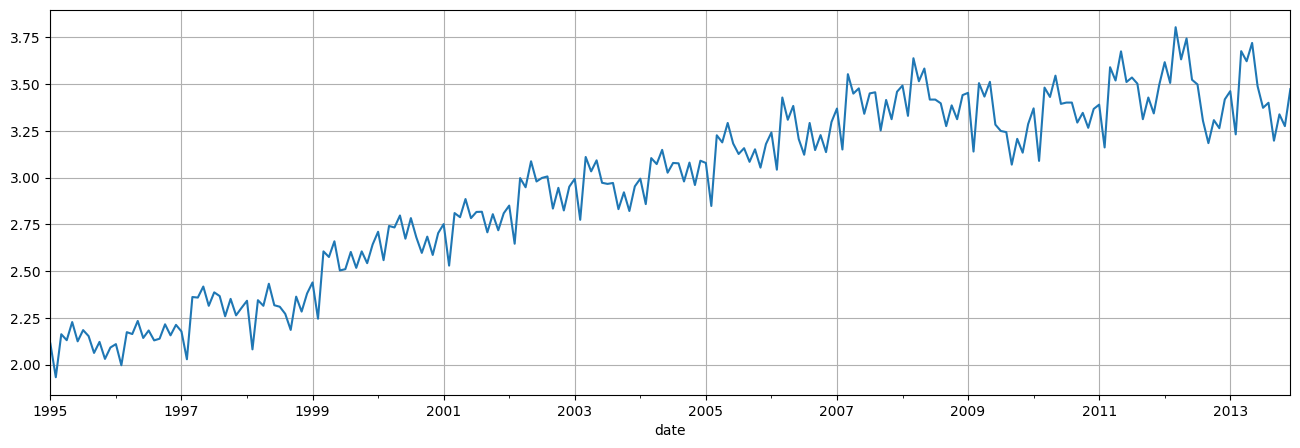

In [23]:
plot_features = df_milk['Milk.Prod']
plot_features.index = date_time
_ = plot_features.plot(subplots=True, figsize = (16,5))
plt.grid(True)
plt.show()

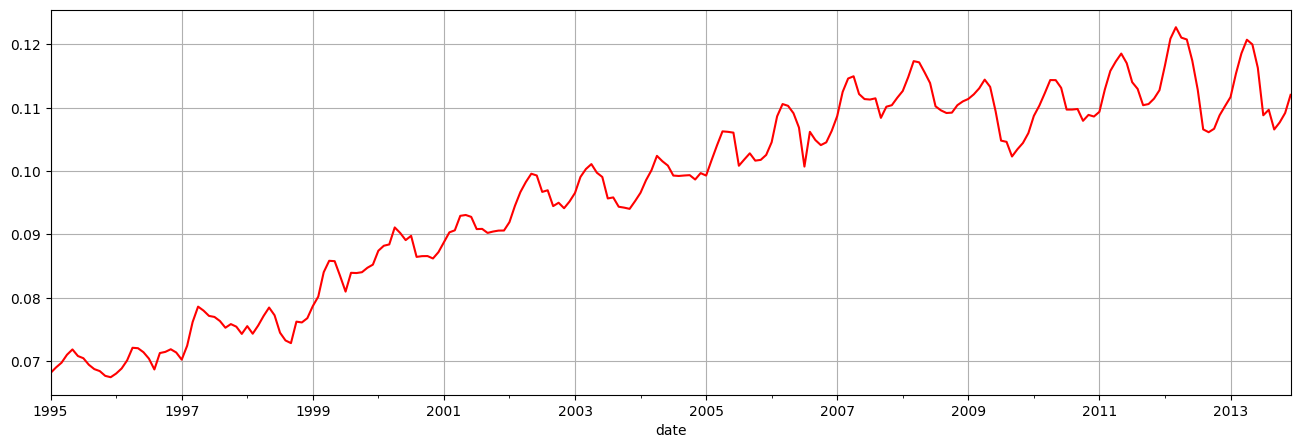

In [24]:
plot_features = df_milk['Corrigido']
plot_features.index = date_time
_ = plot_features.plot(subplots=True, figsize = (16,5), color='r')
plt.grid(True)
plt.show()

CONCLUSÕES:

* O padrão de repetição sazonal torna-se mais evidente quando se usa a produção média diária de leite ao invés da produção mensal de leite.

* A média de produção diária remove a variação devida ao número diferente de dias em cada mês $\to$ séries mais simples são mais fáceis de modelar fazendo com que as previsões sejam mais precisas. 

### 3.2 Ajustes populacionais

Quaisquer dados que dependam de mudanças populacionais podem ser ajustados para fornecer dados *per capita*. Ou seja, os dados passam a representar o fenônemo por pessoa (ou por mil pessoas, ou por milhão de pessoas) em vez do total de pessoas.

Por exemplo, se os dados representarem o número de leitos hospitalares em uma determinada região ao longo do tempo, os resultados serão muito mais fáceis de se interpretar quando forem removidos os efeitos das mudanças populacionais, considerando, por exemplo, o número de leitos por mil pessoas.

Dessa forma, é possível checar se houve aumento real no número de leitos, ou se o aumento se deve simplesmente ao crescimento da população. É possível que o número total de leitos aumente, enquanto o número de leitos por mil pessoas diminua. Isso ocorre quando a população está crescendo mais rapidamente do que o número de leitos hospitalares.

Para a maioria dos dados que dependem de mudanças populacionais, a melhor estratégia é usar dados *per capita* ao invés dos totais.

### 3.3 Ajustes de inflação

Recomenda-se que dados relacionados a valores monetários sejam ajustados antes de qualquer modelagem. 

Por exemplo, o custo médio de uma casa nova sofreu aumento nas últimas décadas devido à inflação. Uma casa de 2 milhões em 2023 não representa o padrão de uma casa de 2 milhôes há vinte anos atrás. 

As séries temporais financeiras geralmente são ajustadas para que todos os valores sejam expressos em valores monetários de um determinado momento. Para fazer esses ajustes, é necessário obter e usar algum índice de inflação. 


### 3.4 Transformações matemáticas

Se os dados indicam variações que aumentam ou diminuem com o nível da série, então a aplicasção de uma transformação matemática pode ser útil. 


#### Transformação logarítmica

Uma transformação logarítmica da seguinte forma é frequentemente útil:

$$ w_t = log(y_t)$$

em que $y_t$ é o valor original da série no instante de tempo $t$ e $w_t$ é o seu valor transformado. 

Empregar uma função logaritmica é útil na medida em que:

* As alterações em um valor de $\log$ são alterações relativas na escala original $\to$ se for usada a base logarítmica 10, um aumento de 1 na escala logarítmica corresponde a uma multiplicação de 10 na escala original;

* Restringe as previsões para que permaneçam positivas na escala original.


#### Valor de retorno

Uma transformação muito usada na área financeira, especialmente quando se analisa o mercado de câmbio ou de ações, é modificar o preço de acordo com a seguinte equação: 

$$r_t = \log\left(\frac{p_t}{p_{t-1}}\right)$$

em que $r_t$ é o retorno, $p_t$ é o preço no instante $t$ e $p_{t-1}$ é o preço no instante de tempo anterior, $t-1$. 

A vantagem de usar essa transformação é que o retorno tende a uma distribuiçção com média zero e sua variação torna-se fácil de interpretar:

* um valor de retorno positivo significa aumento de preço;
* um valor de retorno negativo significa diminuição de preço.


#### Transformações de potência

Outras transformações também são usadas, como por exemplo, raízes quadradas e raízes cúbicas. Essas transformações podem ser escritas da seguinte forma:

$$w_t = \frac {y_t^\lambda} {\lambda}, \text{com } 0<\lambda<1$$

Esse tipo de transformação é usada para diminuir as variações que ocorrem em função da sua magnitude dos dados, de forma a fazer com que tais variações se tornem da mesma ordem de grandeza em qualquer instante de tempo da série.

Um bom valor para $\lambda$ deve fazer com que a variação sazonal seja a mesma em toda a série, tornando mais fácil realizar previsões precisas.


#### Outras transformações

Existem muitas outras transfromações que podem ser aplicadas aos dados de uma série temporal para facilitar o processo de previsão, tais como:

- Transformada de Fourier;
- Transformada cosseno;
- Transformada *wavelets*;
- etc.

### 3.5 Exemplo

Para exemplicar algumas transformações, vamos usar o conjunto de dados "EUR USD Forex Pair Historical Data (2002 - 2020)" do Kaggle (https://www.kaggle.com/datasets/imetomi/eur-usd-forex-pair-historical-data-2002-2019?select=eurusd_hour.csv). Vamos filtrar os dados para que exibam somente os valores de fechamento do dia.

In [25]:
# Carregamento dos dados
df_forex = pd.read_csv('/content/drive/MyDrive/Datasets/eurusd_hour.csv')
display(df_forex.head())
print(f'Formato do conjunto de dados original = {df_forex.shape}')

# Selecionando somente as linhas com os dados de fechamento do dia
df_forex = df_forex[23::24]
display(df_forex.head())
print(f'Formato do conjunto de dados filtrado = {df_forex.shape}')

,Date,Time,BO,BH,BL,BC,BCh,AO,AH,AL,AC,ACh
0,2005-05-02,00:00,1.2852,1.2852,1.2840,1.2844,-0.0008,1.2854,1.2854,1.2842,1.2846,-0.0008
1,2005-05-02,01:00,1.2844,1.2848,1.2839,1.2842,-0.0002,1.2846,1.2850,1.2841,1.2844,-0.0002
2,2005-05-02,02:00,1.2843,1.2854,1.2841,1.2851,0.0008,1.2845,1.2856,1.2843,1.2853,0.0008
3,2005-05-02,03:00,1.2851,1.2859,1.2850,1.2851,0.0000,1.2853,1.2861,1.2852,1.2853,0.0000
4,2005-05-02,04:00,1.2852,1.2859,1.2849,1.2855,0.0003,1.2854,1.2861,1.2851,1.2857,0.0003


Formato do conjunto de dados original = (93084, 12)


,Date,Time,BO,BH,BL,BC,BCh,AO,AH,AL,AC,ACh
23,2005-05-02,23:00,1.28440,1.28580,1.28440,1.28540,0.00100,1.28460,1.28600,1.28460,1.28560,0.00100
47,2005-05-03,23:00,1.28853,1.28853,1.28763,1.28783,-0.00070,1.28868,1.28868,1.28778,1.28798,-0.00070
71,2005-05-04,23:00,1.29470,1.29520,1.29410,1.29430,-0.00040,1.29490,1.29540,1.29430,1.29450,-0.00040
95,2005-05-05,23:00,1.29520,1.29530,1.29450,1.29450,-0.00070,1.29540,1.29550,1.29470,1.29470,-0.00070
119,2005-05-08,23:00,1.28115,1.28180,1.28090,1.28100,-0.00015,1.28215,1.28280,1.28190,1.28200,-0.00015


Formato do conjunto de dados filtrado = (3878, 12)


A coluna BC traz a taxa de fechamento do preço das ações. Ela será o alvo de nossa análise. 

In [26]:
# Separa coluna da data
date = df_forex.pop('Date')

# Separa coluna de taxa de fechamento
df_forex = df_forex.pop('BC')
df_forex.head()

23     1.28540
47     1.28783
71     1.29430
95     1.29450
119    1.28100
Name: BC, dtype: float64

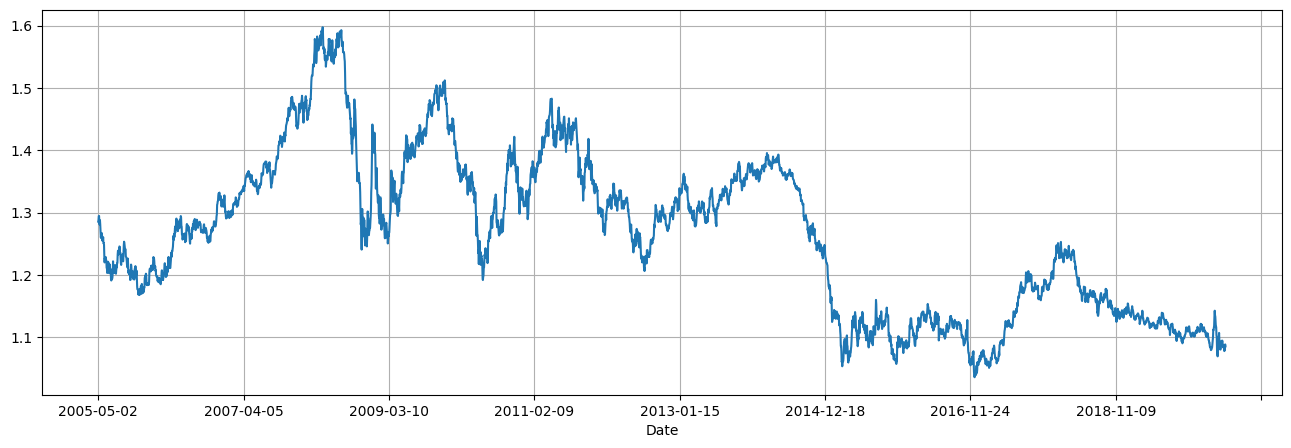

In [27]:
plot_features = df_forex
plot_features.index = date
_ = plot_features.plot(subplots=True, figsize = (16,5))
plt.grid(True)
plt.show()

### Valor de retorno

In [28]:
# Calculo do retorno
linhas = df_forex.shape[0]
df_retorno = np.log(df_forex[-(linhas-1):].div(df_forex[:(linhas-1)].values))
df_retorno.head()

Date
2005-05-03    0.001889
2005-05-04    0.005011
2005-05-05    0.000155
2005-05-08   -0.010483
2005-05-09    0.002729
Name: BC, dtype: float64

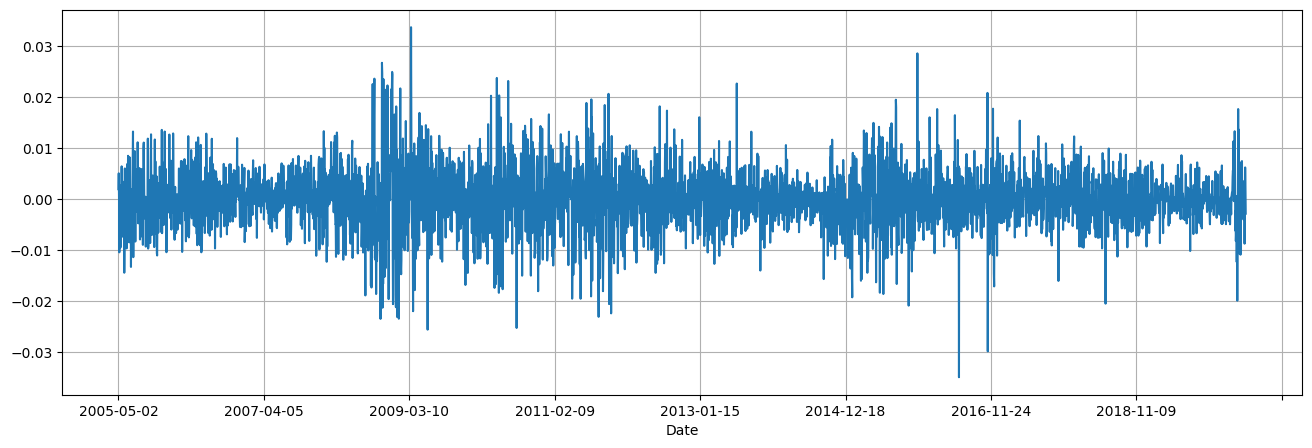

In [29]:
plot_features = df_retorno[:(linhas-1)]
plot_features.index = date[:(linhas-1)]
_ = plot_features.plot(subplots=True, figsize = (16,5))
plt.grid(True)
plt.show()

**IMPORTANTE:** Se existir algum padrão nos dados originais, ele permanecerá na transformação de valoir de retorno. Por outro lado, se não existir nenhum padrão, o valor de retorno será um (quase) ruído branco.

In [30]:
print(f'Média do valor de retorno = {np.mean(df_retorno):.6f}')
print(f'Desvio padrão do valor de retorno = {np.std(df_retorno):.6f}')

Média do valor de retorno = -0.000044
Desvio padrão do valor de retorno = 0.005954


### Transformada Cosseno

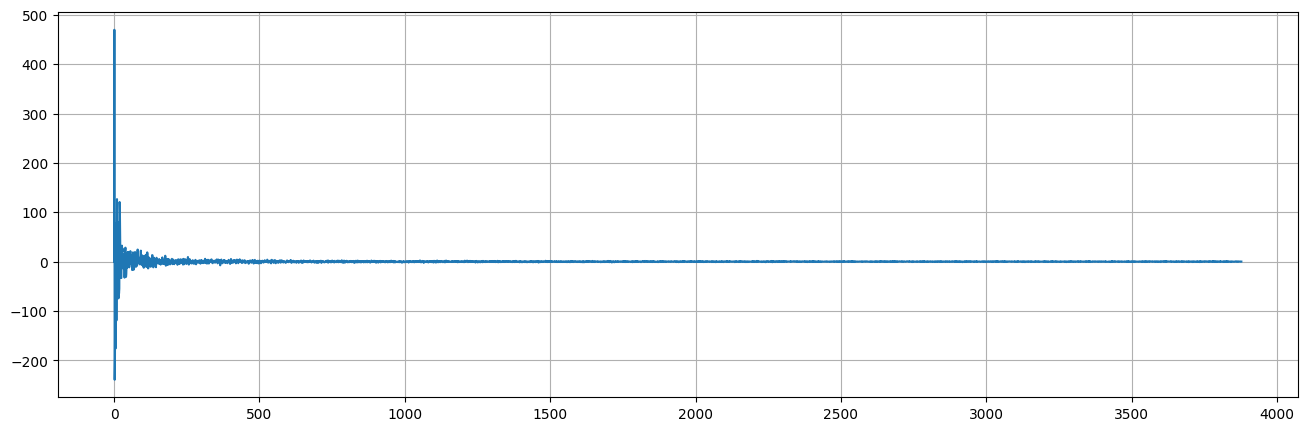

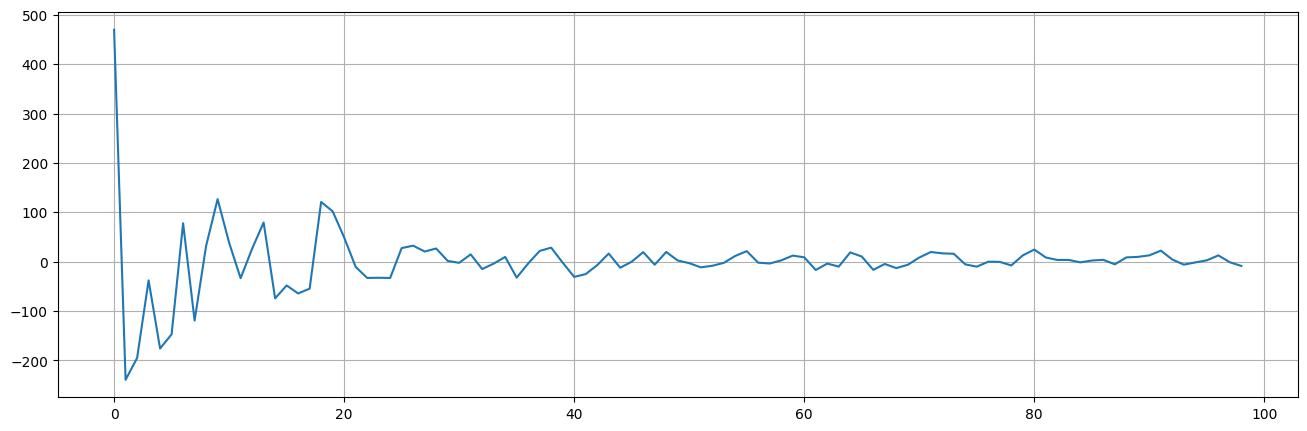

In [31]:
# Importação da função para o cálculo da Transformação Cosseno
from scipy import fft

# Calcula TC (dct = Discrete Cosine Transform)
# Devemos subtrair a média dos dados originais
Cn = fft.dct(np.array(df_forex) - np.mean(df_forex))

# Grafico da TC completo
plt.figure(figsize=(16,5))
plt.plot(Cn)
plt.grid(True)
plt.show()

# Gráfico da TC para baixas frequências
plt.figure(figsize=(16,5))
plt.plot(Cn[1:100])
plt.grid(True)
plt.show()

- Observe que a magnitude dos coeficientes da Transformada Cosseno são pequenos para $n > 40$. Isso indica que é possível reconstruir a série temporal usando um conjunto restrito de componentes harmônicas e, consequentemente, reduzindo sua complexidade. De fato, uma grande aplicação da Tranformada Cosseno é a compressão de dados (especialemnte em imagens). 

### 3.6 Pré processamento dos dados

Na grande maioria dos casos é melhor pré-processar os dados de forma a normalizá-los. A normalização é uma necessidade quando utilizamos uma rede neural para realizar previsões da série ou para detectar anomalias. Para outros métodos a normalização não é uma etapa obrigatória, mas em geral resulta em previsões melhores.

## 4. Resíduo

Os “resíduos” em um modelo de série temporal são as diferenças entre os valores reais e os valores previstos pelo modelo, ou seja:

$$e_t = y_t - \hat {y_t}$$

em que $e_t$ é o resíduo no instante de tempo $t$, $y_t$ e $\hat {y_t}$ são, respectivamente, o valor real e o valor previsto da série pelo modelo no instante de tempo $t$. Os resíduos são úteis para verificar se um modelo capturou adequadamente as informações nos dados. 

Um bom método de previsão deve produzir resíduos:

* não correlacionados $\to$ se houver correlações entre os resíduos, então há informações deixadas nos resíduos que devem ser usadas no cálculo das previsões.

* com média zero $\to$ se os resíduos tiverem uma média diferente de zero, as previsões são tendenciosas.

Qualquer método de previsão que não satisfaz essas propriedades pode ser melhorado. No entanto, isso não significa que os métodos de previsão que satisfaçam essas propriedades não possam ser melhorados. 

É possível que vários métodos de previsão diferentes sejam aplicados ao mesmo conjunto de dados, todos eles satisfazendo as propriedades desejadas. Verificar tais propriedades é importante para checar se o método de previsão está usando todas as informações disponíveis, mas não é uma boa maneira para selecionar um método de previsão.

Se qualquer uma das propriedades desejadas para os resíduos não for satisfeita, o método de previsão pode ser modificado para fornecer melhores previsões. Por exemplo, ajustar um modelo para eliminar viés é simples: se os resíduos tiverem média $\bar {e}$, basta adicionar $\bar{e}$ aos valores previstos e o problema de viés será resolvido. Corrigir o problema de correlação é uma tarefa mais difícil.

Além das propriedades essenciais, é útil (mas não necessário) que os resíduos também tenham:

* variância constante;
* distribuição normal.

Às vezes, aplicar uma transformação de potência aos dados pode ajudar no alcance dessas propriedades, mas geralmente há pouco podemos fazer para garantir que os resíduos tenham variância constante e distribuição normal. 

### 4.1 Exemplo

Vamos voltar a série de produção de cerveja e calcular os resíduos gerados pelas previsões realizadas pelos métodos base, tendência simples e sazonalidade. Em seguida, vamos investigar a sua distribuição de probabilidades.

In [32]:
# Cálculo dos resíduos
e_base = df_beer['Monthly beer production'] - y_base_beer
e_trend = df_beer['Monthly beer production'] - y_trend_beer
e_sazonal = df_beer['Monthly beer production'] - y_sazonal_beer

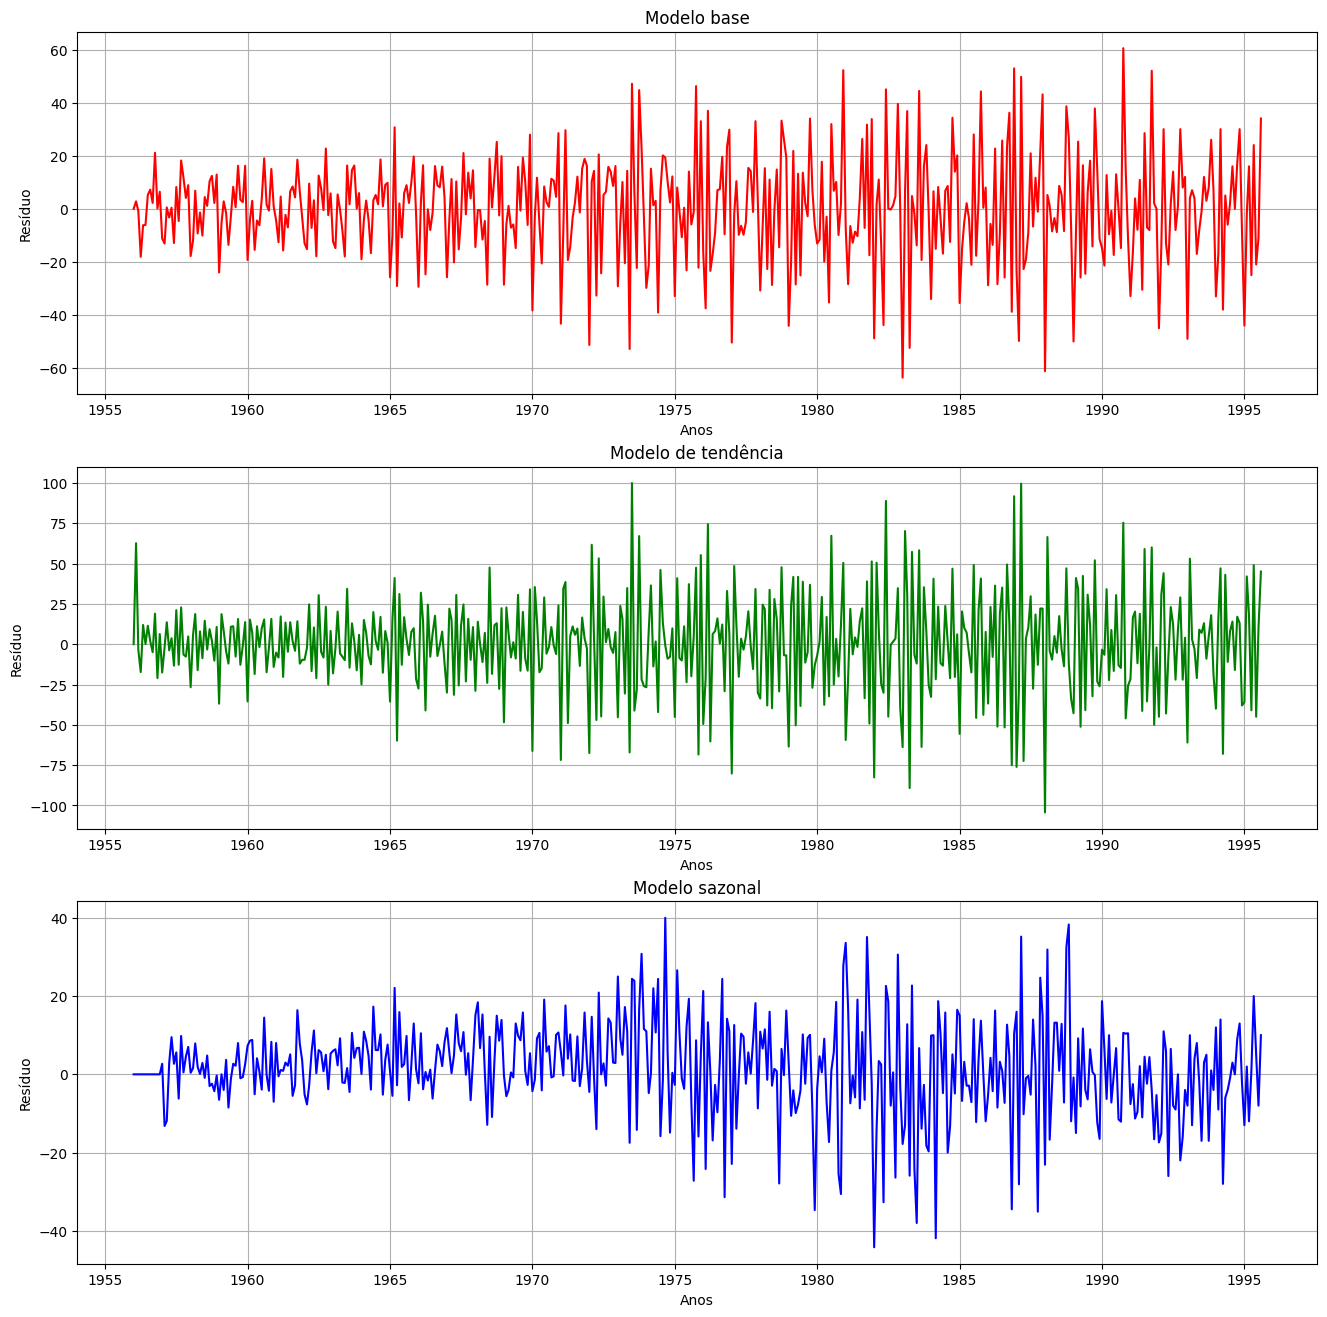

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16,16))
plt.title('Resíduos - Produção de Cerveja')

ax1.plot(month, e_base, 'r')
ax1.set_title('Modelo base')
ax1.set_ylabel('Resíduo')
ax1.set_xlabel('Anos')
ax1.grid(True)

ax2.plot(month, e_trend, 'g')
ax2.set_title('Modelo de tendência')
ax2.set_ylabel('Resíduo')
ax2.set_xlabel('Anos')
ax2.grid(True)

ax3.plot(month, e_sazonal, 'b')
ax3.set_title('Modelo sazonal')
ax3.set_ylabel('Resíduo')
ax3.set_xlabel('Anos')
ax3.grid(True)
plt.show()

* Observa-se que a variação dos resíduos sofre ligeiras alterações ao longo do tempo, com a presença de alguns picos e vales mais pronunciados.

* O ideal seria que os resíduos apresentassem variação constante ao longo do tempo.

Para avaliar as previsões realizadas pelos métodos base, tendência e sazonalidade, podemos:

1. Calcular a distribuição de probabilidade dos resíduos;
2. Calcular a  autocorrelação dos resíduos.

Se as previsões forem "boas", os resíduos devem ter uma distribuição de probabilidade gaussiana e a sua auto-correlação deve ser zero para qualquer instante de tempo.

#### Distribuição de probabilidade

A distribuição de probabilidade dos resíduos pode ser calculada usando o histograma normalizado dos resíduos. A comparação desses histogramas com uma distribuição normal de mesmo desvio padrão é feita sobrepondo os gráficos.

In [34]:
# Cálculo dos desvios-padrão
std_base = np.std(e_base)
std_sazonal = np.std(e_sazonal)
std_trend = np.std(e_trend)

print(f'Desvio padrão - método base = {std_base:.3f}')
print(f'Desvio padrão - método sazonal = {std_sazonal:.3f}')
print(f'Desvio padrão - método tendencia = {std_trend:.3f}')

# Cosntrução das respectivas distribuições normais
from math import pi
x = np.linspace(-100, 100, num=100)
normal_base = np.exp((-x**2)/(2*std_base**2))/(np.sqrt(2*pi*std_base**2))
normal_sazonal = np.exp((-x**2)/(2*std_sazonal**2))/(np.sqrt(2*pi*std_sazonal**2))
normal_trend = np.exp((-x**2)/(2*std_trend**2))/(np.sqrt(2*pi*std_trend**2))

Desvio padrão - método base = 19.612
Desvio padrão - método sazonal = 12.257
Desvio padrão - método tendencia = 30.825


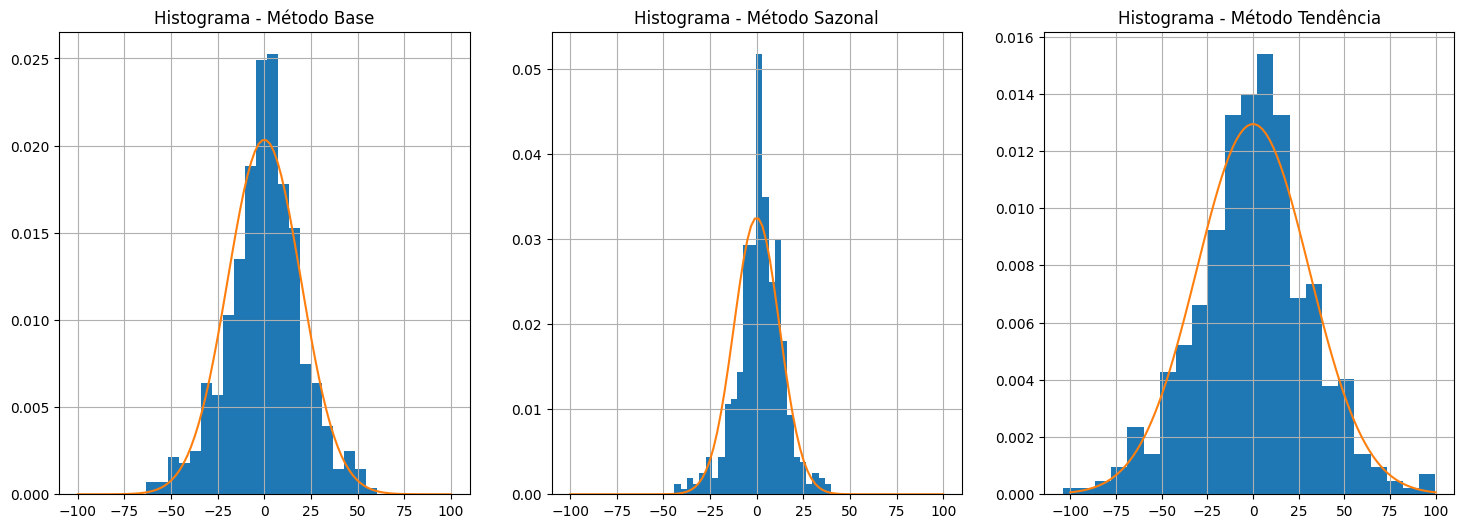

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))

ax1.hist(e_base, bins='auto', density=True) 
ax1.plot(x, normal_base)
ax1.grid(True)
ax1.set_title("Histograma - Método Base")

ax2.hist(e_sazonal, bins='auto', density=True) 
ax2.plot(x, normal_sazonal)
ax2.grid(True)
ax2.set_title("Histograma - Método Sazonal")

ax3.hist(e_trend, bins='auto', density=True) 
ax3.plot(x, normal_trend)
ax3.set_title("Histograma - Método Tendência")
ax3.grid(True)
plt.show()

Os gráficos anteriores mostram que, do ponto de vista da distribuição de probabilidade, os métodos base, tendência e sazonalidade produzem previsões cujas distribuições de probabilidade não se afastam muito da distribuição normal de média zero e desvio padrão respectivo ao método. Isso sugere que tais métodos não são de fato ruins.

Algumas observações:

* o método sazonal apresenta as melhores previsões, pois possui o menor desvio padrão dos resíduos e a distribuição de probablidadde mais próxima de uma gaussiana. 

* o método de tendência apresenta a pior previsão, uma vez que possui os devios com o maior desvio padrão.

#### Autocorrelação

In [36]:
# Define função para calcular autocorrelação normalizada
def autocorr(x):
    x = x - np.mean(x)
    result = np.correlate(x, x, mode='full')
    maxcorr = np.argmax(result)
    acorr = result / result[maxcorr]
    n2 = int(np.round(len(acorr)/2))
    return acorr[n2:]

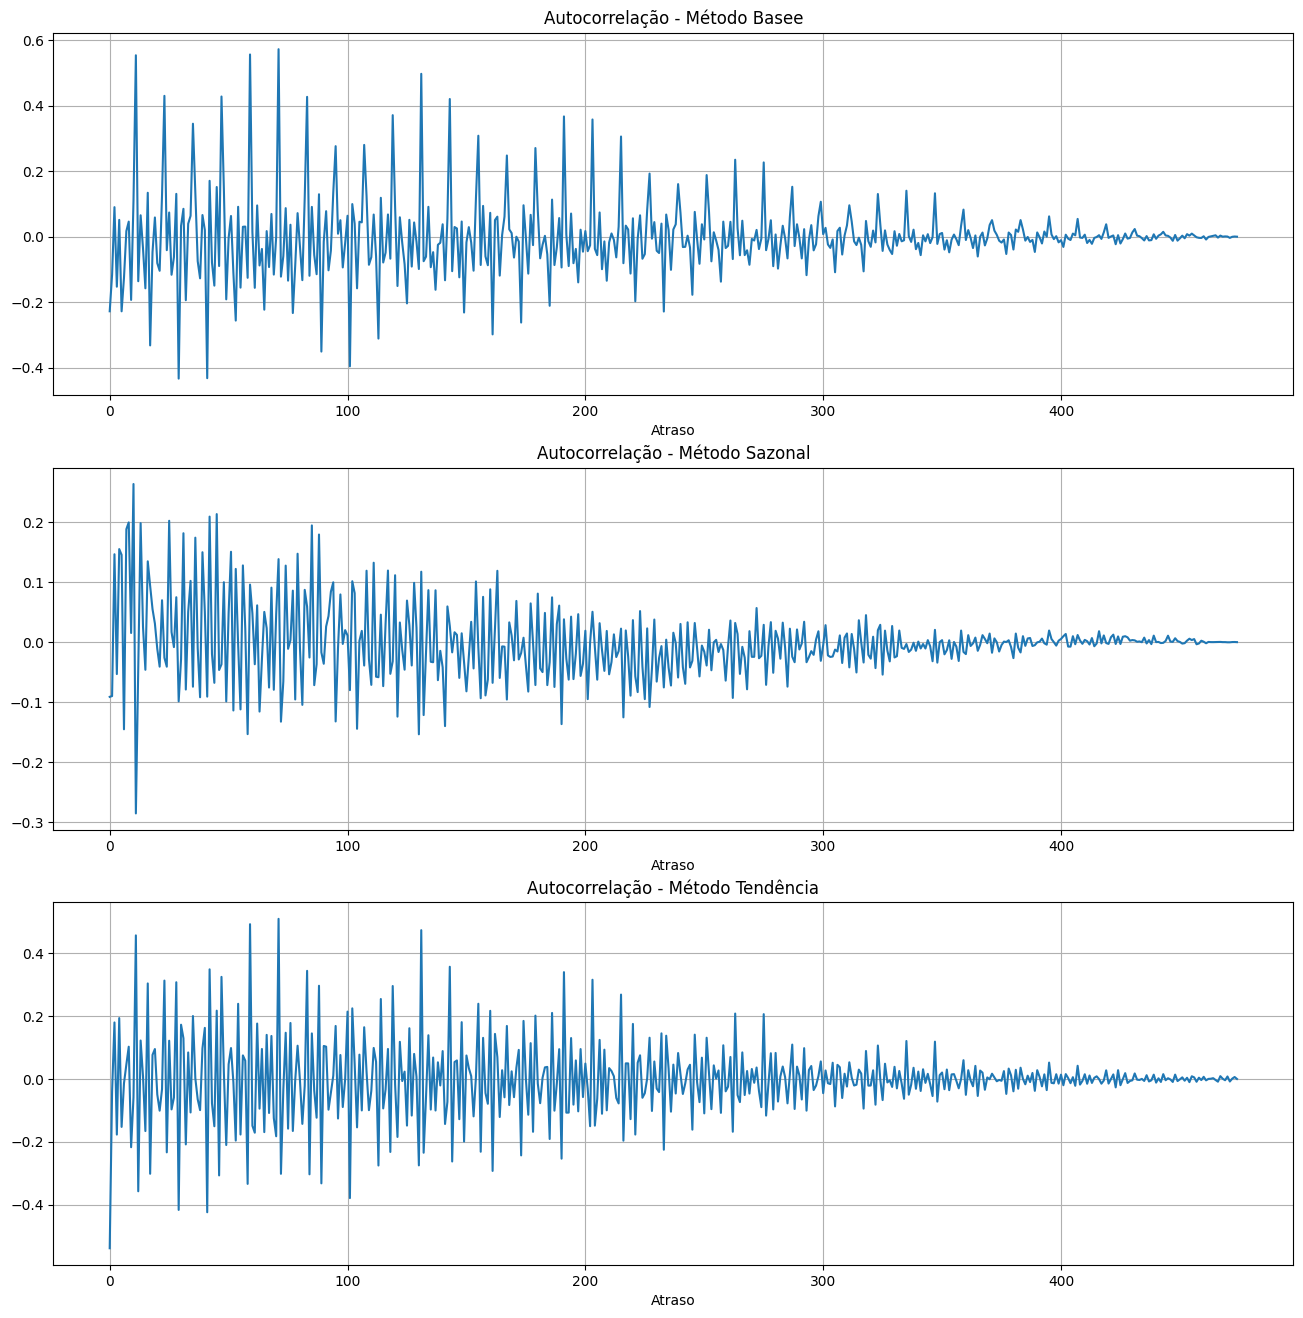

In [37]:
# Cálculo das autocorrelações
R_base = autocorr(e_base)
R_sazonal = autocorr(e_sazonal)
R_trend = autocorr(e_trend)

# Representações gráficas
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16,16))
ax1.set_title('Autocorrelação - Método Basee')
ax1.plot(R_base)
ax1.set_xlabel('Atraso')
ax1.grid(True)

ax2.set_title('Autocorrelação - Método Sazonal')
ax2.plot(R_sazonal)
ax2.set_xlabel('Atraso')
ax2.grid(True)

ax3.set_title('Autocorrelação - Método Tendência')
ax3.plot(R_trend)
ax3.set_xlabel('Atraso')
ax3.grid(True)

plt.show()

Se as previsões fossem razoáveis, era esperado que os resíduos fossem ruídos brancos, cujos coeficientes da autocorrelação são aproximadamente todos iguais a zero. 

Na prática, para um ruído branco espera-se que 95% dos picos da autocorrelação estejam dentro do intervalo $±2/ \sqrt(N)$, em que $N$ é o número de amostras da série. Se mais do que 5% dos picos estiverem fora desse intervalo, então, a série não é um ruído branco.

No caso da série de produção de cerveja temos $N=476$. Então, $±2/ \sqrt(476) = 0,092$ $\rightarrow$ dos gráficos das autocorrelações, pode-se ver que muitos picos estão fora desse intervalo, mostrando que os resíduos apresentam uma forte autocorrelação, confirmando que as previsões não são muito satisfatórias.

O método cuja autocorrelação apresenta os menores valores é o sazonal. Portanto, é o que produz as melhores previsões para essa série.

As mesmas conclusões podem ser obtidas ao analisarmos os diagramas ACF a seguir. Neles, adotamos `lags=200`.

Método Base


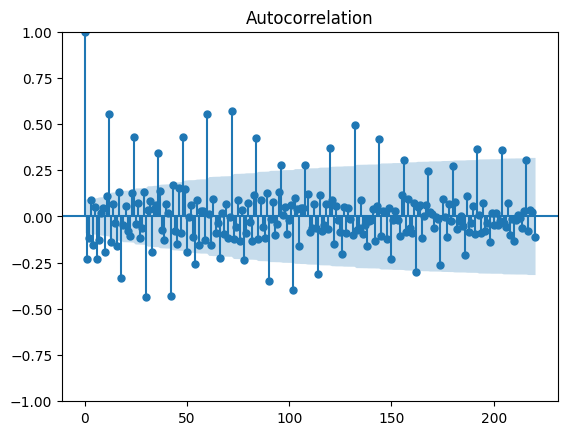

Método Sazonal


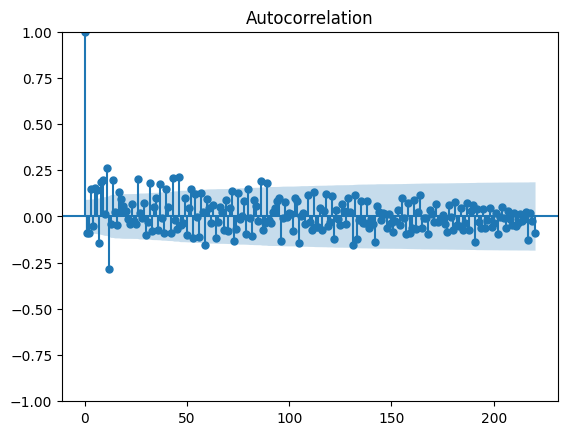

Método de tendência


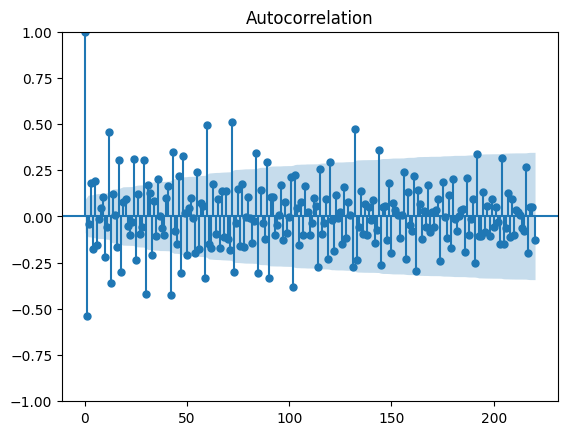

In [38]:
from statsmodels.graphics.tsaplots import plot_acf

# Diagramas ACF
# Método base
print('Método Base')
plot_acf(e_base, lags=220)
plt.show()

# Método Sazonal
print('Método Sazonal')
plot_acf(e_sazonal, lags=220)
plt.show()

# Método de tendência
print('Método de tendência')
plot_acf(e_trend, lags=220)
plt.show()


## 5. Avaliação de previsões

É muito importante avaliar a precisão das previsões usando dados reais (quando disponíveis). A magnitude dos resíduos não é uma indicação confiável de quão grandes são os erros de previsão.

A precisão das previsões só pode ser determinada considerando o desempenho de um modelo em novos dados que não foram usados no ajuste do modelo.

### 5.1 Divisão dos dados

Ao escolher modelos, é prática comum separar os dados disponíveis em dois conjuntos: (1) dados de treinamento e (2) dados de teste. 

* Os dados de treinamento são usados para estimar quaisquer parâmetros de um método de previsão e os dados de teste são usados para avaliar sua precisão.

* Como os dados de teste não são usados para determinar as previsões, eles fornecem uma indicação confiável de quão bem o modelo prevê novos dados.

Na figura abaixo é mostrado como dividir os dados de uma série temporal.

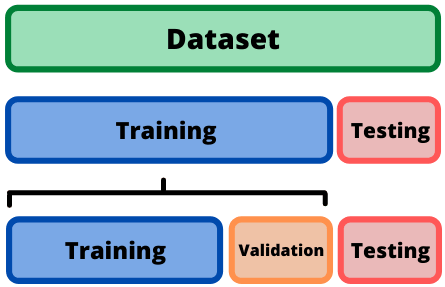

O tamanho do conjunto de teste é normalmente cerca de 20% da amostra total, embora esse valor dependa do número total de amostras da série e de quão à frente é desejado realizar previsões. Idealmente, o conjunto de teste deve ser pelo menos tão grande quanto o horizonte de previsão máximo necessário.

Os seguintes pontos devem ser observados.

* Um modelo que se ajusta bem aos dados de treinamento não necessariamente fará uma boa previsão;

* Um ajuste perfeito para os dados de treinamento sempre pode ser obtido usando um modelo com parâmetros suficientes (*overfitting*). Porém, o ajuste excessivo de um modelo aos dados de treinamento é tão ruim quanto não identificar um padrão sistemático nos dados.

### 5.2 Métricas para avaliar previsões e modelos

Antes de começar a fazer previsões é preciso saber como medir a qualidade dessas previsões e, portanto, dos modelos obtidos. As métricas mais usadas na área de séries temporais são as seguintes:

#### 1. R squared ($R^2$):
Coeficiente de determinação (em econometria, pode ser interpretado como sendo a porcentagem da variância explicada pelo modelo):

$$R^2 = 1 - \frac{\sum\limits_{i=1}^{N} (y_i - \hat{y}_i)^2}{\sum\limits_{i=1}^{N} (y_i - \bar{y})^2}$$

em que $y_i$ é um dado da série, $\hat{y}_i$ é o valor previsto para esse dado, $\bar y$ é o valor médio dos dados reais da série e $N$ é o número de dados (amostras) da série.

A função Python para o cálculo do $R^2$ é `sklearn.metrics.r2_score`


#### 2. Erro médio absoluto (MAE):

É uma das métricas mais usadas por ser a mais fácil de ser interpretada.

$$MAE = \frac{\sum\limits_{i=1}^{N} |y_i - \hat{y}_i|}{N}$$

A função unção Python para o cálculo do MAE é `sklearn.metrics.mean_absolute_error`
    
    
#### 3. Erro médio absoluto porcentual (MAEP):

É o mesmo que o MAE, mas é calculado como uma porcentagem (valor mais conveniente quando se quer analisar a qualidade de um resultado).

$$MAEP = \frac{100}{N}\sum\limits_{i=1}^{N} \frac{|y_i - \hat{y}_i|}{y_i}$$ 
    
Observa-se que essa métrica pode gerar problemas se algum valor da série for igual a zero. 
    
#### 4. Erro médio absoluto procentual modificado (MAEPM):

Para eliminar o problema de divisão por zero pode-se usar uma modificação do MAEP.
    
$$MAEPM = \frac{100}{N}\sum\limits_{i=1}^{N} \frac{|y_i - \hat{y}_i|}{\bar y}$$
    
em que $\bar y$ é o valor médio dos dados reais da série.


#### 5. Erro mediano absoluto (MAM):

$$MAM = \text{median}(|y_1 - \hat{y}_1|, ... , |y_N - \hat{y}_N|)$$

A função Python que implementa o MAM é `sklearn.metrics.median_absolute_error`


#### 6. Erro médio quadrátio (MSE):

É uma das métricas mais usadas. Sua característica marcante é que aplica uma penalidade maior para erros grandes.

$$MSE = \frac{1}{N}\sum\limits_{i=1}^{N} (y_i - \hat{y}_i)^2$$

A função Python que calcula o MSE é `sklearn.metrics.mean_squared_error`


#### 7. Erro logarítmico médio (MSLE):

Muito similar ao MSE, sendo calculado como o logaritmo da série. Resulta em aplicar maior peso aos erros pequenos. É usado quando os dados tem tendência exponencial.

$$MSLE = \frac{1}{N}\sum\limits_{i=1}^{N} (log(1+y_i) - log(1+\hat{y}_i))^2$$

A função Python que implementa o MSLE é `sklearn.metrics.mean_squared_log_error`

### 5.3 Exemplos

Vamos calcular algumas métricas das previsões da série de produção de cerveja pelos métodos base, tendência simples e sazonalidade.

In [39]:
# Importação das funções acima do SciKitLearn
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [40]:
# Função para calcular o erro médio absoluto porcentual modificado (MAEPM)
def mean_absolute_percentage_error(y_true, y_pred): 
    return 100*np.mean((np.abs(y_true - y_pred)) / y_true)

In [41]:
# Erro absoluto médio porcentual modificado (MAEPM)
MAP_base = mean_absolute_percentage_error(df_beer['Monthly beer production'], y_base_beer)
MAP_trend = mean_absolute_percentage_error(df_beer['Monthly beer production'], y_trend_beer)
MAP_sazonal = mean_absolute_percentage_error(df_beer['Monthly beer production'], y_sazonal_beer)

print(f'Erro absoluto médio porcentual - Método base = {MAP_base:.2f}%')
print(f'Erro absoluto médio porcentual - Método tendência = {MAP_trend:.2f}%')
print(f'Erro absoluto médio porcentual  - Método sazonal = {MAP_sazonal:.2f}%')

Erro absoluto médio porcentual - Método base = 10.79%
Erro absoluto médio porcentual - Método tendência = 17.25%
Erro absoluto médio porcentual  - Método sazonal = 6.51%


In [42]:
# Erro quadrático médio 
MSE_base = mean_squared_error(df_beer['Monthly beer production'], y_base_beer)
MSE_trend = mean_squared_error(df_beer['Monthly beer production'], y_trend_beer)
MSE_sazonal = mean_squared_error(df_beer['Monthly beer production'], y_sazonal_beer)

print(f'Erro quadrático médio - Método base = {MSE_base:.2f}')
print(f'Erro quadrático médio - Método tendência = {MSE_trend:.2f}')
print(f'Erro quadrático médio - Método sazonal = {MSE_sazonal:.2f}')

Erro quadrático médio - Método base = 384.66
Erro quadrático médio - Método tendência = 950.22
Erro quadrático médio - Método sazonal = 152.71


In [43]:
# R quadrado
R2_base = r2_score(df_beer['Monthly beer production'], y_base_beer)
R2_trend = r2_score(df_beer['Monthly beer production'], y_trend_beer)
R2_sazonal = r2_score(df_beer['Monthly beer production'], y_sazonal_beer)

print(f'R2 score - Método base = {R2_base:.3f}')
print(f'R2 score - Método tendência = {R2_trend:.3f}')
print(f'R2 score - Método sazonal = {R2_sazonal:.3f}')

R2 score - Método base = 0.661
R2 score - Método tendência = 0.163
R2 score - Método sazonal = 0.866


In [44]:
# Erro mediano absoluto
MA_base = median_absolute_error(df_beer['Monthly beer production'], y_base_beer)
MA_trend = median_absolute_error(df_beer['Monthly beer production'], y_trend_beer)
MA_sazonal = median_absolute_error(df_beer['Monthly beer production'], y_sazonal_beer)

print(f'Erro mediano absoluto - Método base = {MA_base:.3f}')
print(f'Erro mediano absoluto - Método tendência = {MA_trend:.3f}')
print(f'Erro mediano absoluto - Método sazonal = {MA_sazonal:.3f}')

Erro mediano absoluto - Método base = 11.650
Erro mediano absoluto - Método tendência = 17.600
Erro mediano absoluto - Método sazonal = 6.750


In [45]:
# Erro logarítmico médio
MLE_base = mean_squared_log_error(df_beer['Monthly beer production'], y_base_beer)
MLE_trend = mean_squared_log_error(df_beer['Monthly beer production'], y_trend_beer)
MLE_sazonal = mean_squared_log_error(df_beer['Monthly beer production'], y_sazonal_beer)

print(f'Erro logarítmico médio - Método base = {MLE_base:.5f}')
print(f'Erro logarítmico médio  - Método tendência = {MLE_trend:.5f}')
print(f'Erro logarítmico médio  - Método sazonal = {MLE_sazonal:.5f}')


Erro logarítmico médio - Método base = 0.01818
Erro logarítmico médio  - Método tendência = 0.05211
Erro logarítmico médio  - Método sazonal = 0.00723


Observa-se que dependendo da métrica utilizada um modelo pode parecer melhor ou pior do que outros. Assim, é recomendável o uso do bom senso.

## 6. Intervalo de confiança

Um intervalo de confiança fornece uma faixa dentro da qual espera-se que a previsão tenha uma probabilidade de acerto determinada. 

Supondo que os erros de previsão tenham uma distribuição de probabilidade normal, um intervalo de confiança de 95% é definido como:

$$\hat y_t \pm 1,96 \sigma$$

em que $\sigma$ é o desvio padrão das previsões.

De forma mais geral, um intervalo de confiança pode ser definido por:

$$\hat y_t \pm c \sigma$$

em que a constante $c$ depende do intervalo que se deseja considerar. Em geral se usa 80% ou 95%, embora outras porcentagens possam ser usadas.

A Tabela abaixo mostra a constante $c$ para vários intervalos.

| Porcentagem | Multiplicador (c) | 
| --- | --- | 
| 50 | 0,67 |
| 60 | 0,84 |
| 70 | 1,04 |
| 80 | 1,28 |
| 90 | 1,64 |
| 99 | 2,54 |

Devemos interpretar os intervalos de confiança como indicativos da incerteza nas previsões. Se produzirmos apenas previsões, não há como dizer quão precisas elas são. No entanto, se também produzirmos intervalos de confiança, fica claro quanta incerteza está associada a cada previsão. 


### 6.1 Distribuição de probabilidade de previsões para o próximo instante de tempo

A distribuição de probabilidade de uma previsão realizada para um único instante de tempo no futuro é praticamente igual à distribuição de probabilidade de todas as previsões $\to$ nesse caso, pode-se usar o desvio padrão dos resíduos para calcular o intervalo de previsão. 

De fato, para uma única previsão no próximo instante de tempo, o desvio padrão das previsões é igual ao desvio padrão dos resíduos quando o modelo não tem nenhum parâmetro a ser estimado $\to$ esse é o caso dos modelos base e de tendência.

Para modelos de previsão que envolvem parâmetros que precisam ser estimados, o desvio padrão das previsões é um pouco maior do que o do resíduos $\to$ porém, em geral essa diferença é ignorada.

No código abaixo é definida uma função para calcular as previsões e o intervalo de confiança de acordo com o método base.

In [46]:
# Modelo base
def BaseModel_2(series, scale):
    N = len(series)
    y = series.copy()
    e = np.zeros(y.shape)
    s = np.zeros(y.shape)
    for t in range(1, N):
        y.iloc[t] = series.iloc[t-1]
        e[t] = y.iloc[t] - series.iloc[t]             
        s[t] = np.std(e[:t])
    y_inf = y - scale*s
    y_sup = y + scale*s
    return y, y_inf, y_sup

- Observe que o desvio padrão do resíduo é atualizado a cada instante de tempo usando a distribuição de probabilidade dos resíduos calculados até esse instante


### Exemplo

Vamos calcular a previsão dos dados de produção de cerveja usando o método base, juntamente com o intervalo de confiação de 95%.

In [63]:
# Calcula a previsão para a próxima hora usando modelo base 
scale = 1.96
y, y_inf, y_sup = BaseModel_2(df_beer['Monthly beer production'], scale)

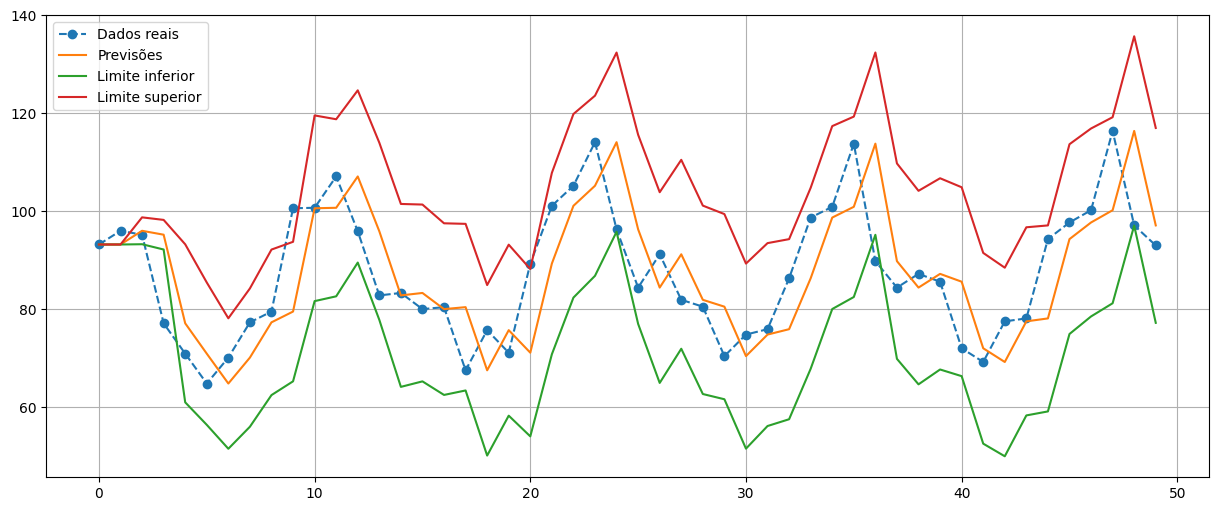

In [64]:
plt.figure(figsize=(15, 6))
plt.plot(df_beer[:50], 'o--', label='Dados reais')
plt.plot(y[:50], label='Previsões')
plt.plot(y_inf[:50], label='Limite inferior')
plt.plot(y_sup[:50], label='Limite superior')
plt.legend()
plt.grid(True)
plt.show()

### 6.2 Distribuição de probabilidade de previsões para múltiplos instantes de tempo

Uma característica do intervalo de confiança é que ele aumenta na medida em que o horizonte de previsão aumenta. Quanto mais à frente prevermos, mais incerteza estará associada à previsão e, portanto, maiores serão os intervalos de confiança.
Assim, em geral $\sigma$ aumenta com o horizonte de previsão.

Para produzir um intervalo de confiança é necessário ter uma estimativa do desvio padrão para cada previsão. Como já observado, para previsões do próximo instante de tempo o desvio padrão dos resíduos fornece uma boa estimativa do desvio padrão das previsões. Contudo, para previsões de múltiplos instantes de tempo é necessário um método de cálculo mais elaborado. Esses cálculos assumem que os resíduos não são correlacionados.

Para os três métodos simples vistos, é possível demonstrar matematicamente que o desvio padrão das previsôes está relacionado com o desvio padrão dos resíduos de acordo com as seguintes equações:


1. #### Método base:

  $$\sigma_p = \sigma_r \sqrt{p}$$

   em que $p$ é o número de instantes de tempo no futuro, $\sigma_p$ é o desvio padrão da previsão no instante de tempo $t+pT_a$ no futuro e $\sigma_r$ é o desvio padrão dos resíduos calculados até o instante de tempo presente ($t$).
   

2. #### Método de tendência simples

  $$\sigma_p = \sigma_r \sqrt{p \big(1+ \frac {p}{N} \big)}$$

  em que $N$ é o número de amostras consideradas para calcular o desvio padrão dos resíduos.
  
  
3. #### Método sazonal

  $$\sigma_p = \sigma_r \sqrt{ \big \lfloor{ \frac {p - 1}{m}} \big \rfloor}$$

   em que $m$ é o período das temporadas e o símbolo $\lfloor{ . \rfloor}$ representa a operação de truncagem para o menor inteiro.
   
   
4. #### Método de média móvel

    Para o método da média móvel também é possível demonstrar analicamente que o desvio padrão das previsões no futuro é dado por:
    
    $$\sigma_p = \sigma_r \sqrt{\big(1+ \frac {1}{N} \big)}$$
    
    em que $N$ é o número de amostras utilizado para calcular o desvio padrão dos resíduos.
   
   
   
### Exemplo:

Vamos calcular a previsão dos dados de produção de cerveja usando o método base para 12 meses no futuro, a partir do instante de tempo de 48 meses, e  visualizar o intervalo de confiança dessas previsões.

(48,) (48, 1)
(12,) (12,)


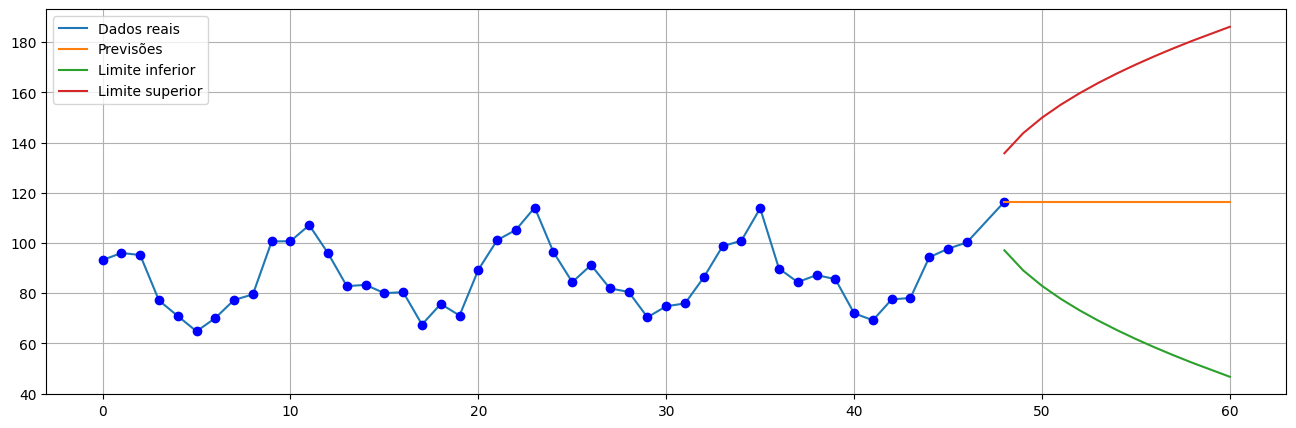

In [73]:
scale = 1.96
y, y_inf, y_sup = BaseModel_2(df_beer['Monthly beer production'], scale)

# Escala de tempo
t = np.linspace(0, 48, num=48, dtype=int)

# Escala de tempo no futuro
t_fut = np.linspace(48, 60, num=12, dtype=int)

# Previsões do futuro usando método basae
y_prev = np.array(df_beer.iloc[47])*np.ones((12,))

# Recalcula desvio padrão das previsões 
s = np.array((y - y_inf)/scale)

# Desvio padrão das previsões futuras
sigma = s[48]*np.sqrt(t_fut - 47)

# Intervalos de confiança
y_inf = y_prev - 1.96*sigma
y_sup = y_prev + 1.96*sigma

print(t.shape, df_beer.iloc[:48].shape)
print(y_inf.shape, y_sup.shape)

plt.figure(figsize=(16,5))
plt.plot(t,df_beer[:48], label='Dados reais')
plt.plot(t,df_beer[:48], 'bo')
plt.plot(t_fut,y_prev, label='Previsões')
plt.plot(t_fut, y_inf, label='Limite inferior')
plt.plot(t_fut, y_sup, label='Limite superior')
plt.legend()
plt.grid(True)
plt.show()

- Observe que, como esperado, o intervalo de confiança aumenta na medida em que as previsões são realizadas mais no futuro $\to$ isso indica que as previsões têm cada vez mais incerteza.